<a href="https://colab.research.google.com/github/karoldem/Rekrutacja_2023/blob/main/Rekrutacja_ko%C5%82o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First get our data:

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import QuantileTransformer as qt
from pandas.plotting import scatter_matrix

df = pd.read_csv('https://raw.githubusercontent.com/Kolo-Naukowe-Data-Science-PW/Rekrutacja_2023/main/spaceship_titanic/dane.csv')
df['CryoSleep'] = df['CryoSleep'].astype('bool')
df['VIP'] = df['VIP'].astype('bool')
df[['Deck','CabinNum', 'Side']] = df["Cabin"].str.split("/", n = 2, expand = True)
df = df.drop('Cabin', axis=1)
df = df.drop('PassengerId', axis=1)
df = df.drop('Name', axis=1)

I expect all expenses to be "alike", so...

In [121]:
expenses = ['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
expensesBool = [ i + 'Bool' for i in expenses]
categories = ['HomePlanet', 'Destination', 'Deck', 'Side', 'CryoSleep', 'VIP', 'Transported']
nonBinaryCategories = ['HomePlanet', 'Destination']

In [122]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


Looks like 1% is making spending most of money here.

In [123]:
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNum,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,98,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1499,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,1500,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,608,S


Yes, not only 1% is spending most of money, but also seems like even touching certain area is very predictive.

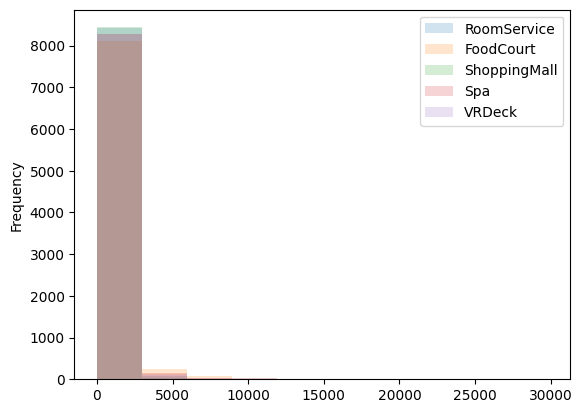

In [124]:
df[expenses].plot.hist(alpha = 0.2);

As we see, we need a logspace.

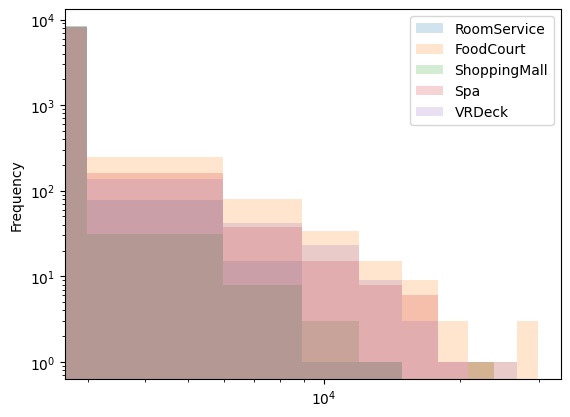

In [125]:
df[expenses].plot.hist(alpha = 0.2, logy=True, logx = True);

Now it is clearly visible that we need to get zeros into another feature and use logscale.

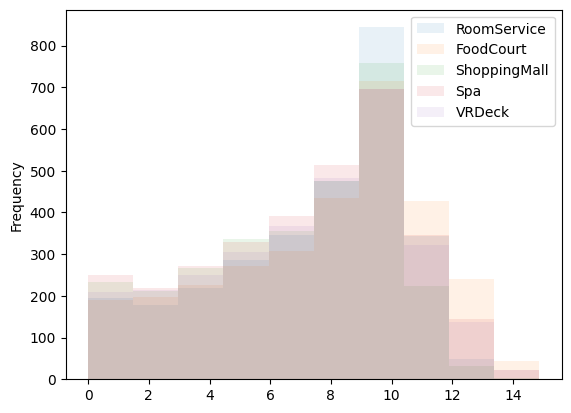

In [126]:
df1 = df.copy()

for i in expenses:
    df1[i + 'Bool'] = df1[i] > 0
    df1.loc[df1[i] == 0, [i]] = None
    df1[i] = np.log2(df1[i])

df1[expenses].plot.hist(alpha = 0.1);

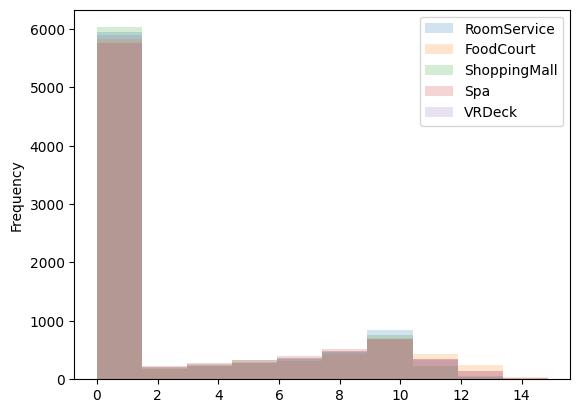

In [127]:
df1 = df.copy()
for i in expenses:
    df1[i + 'Bool'] = df1[i] > 0
    df1.loc[df1[i] == 0, [i]] = None
    df1[i] = np.log2(df1[i])
    df1.loc[df1[i].isna(), [i]] = 0

df1[expenses].plot.hist(alpha = 0.2);

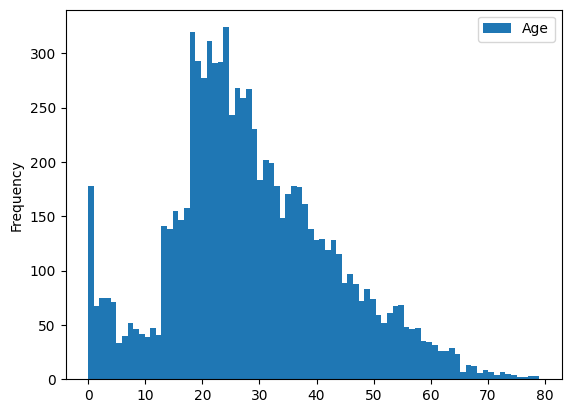

In [128]:
df[['Age']].plot.hist(alpha = 1, bins = 80);

There is slight overrepresentation of zeros, but I judge it as not suspicious enough to remove them.

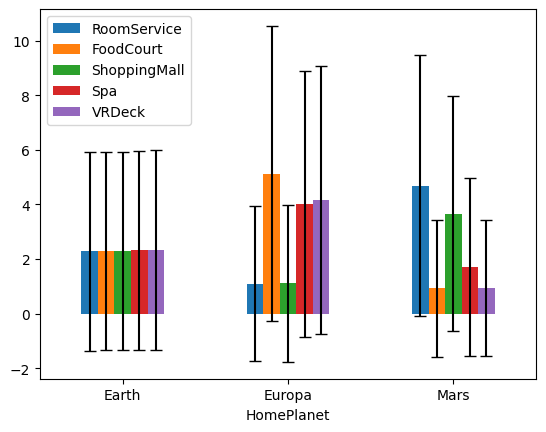

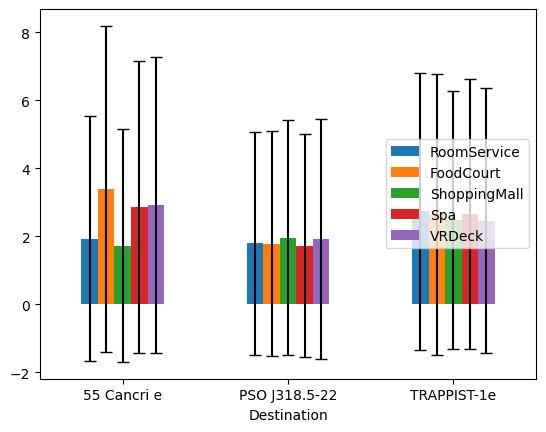

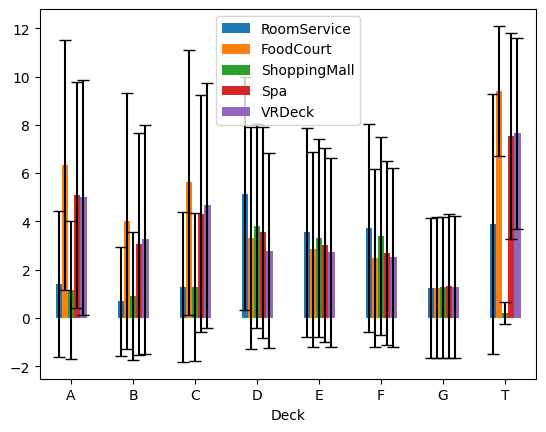

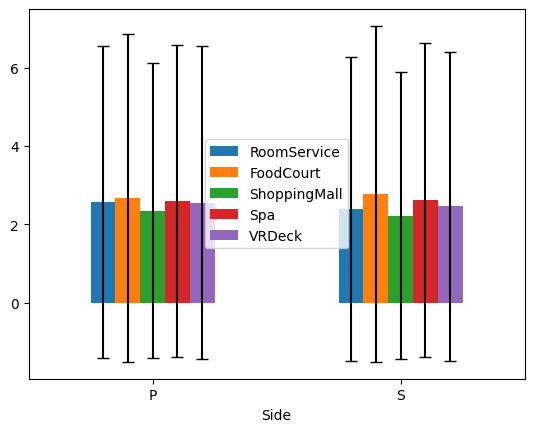

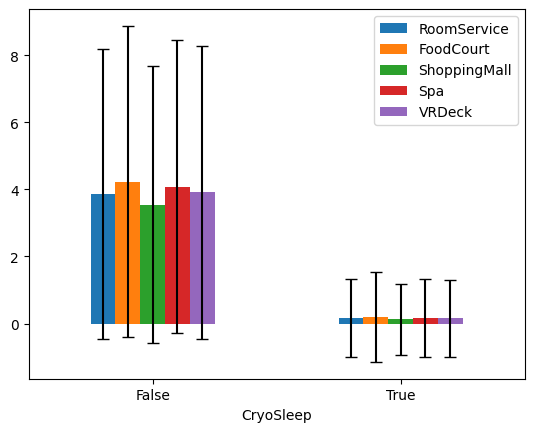

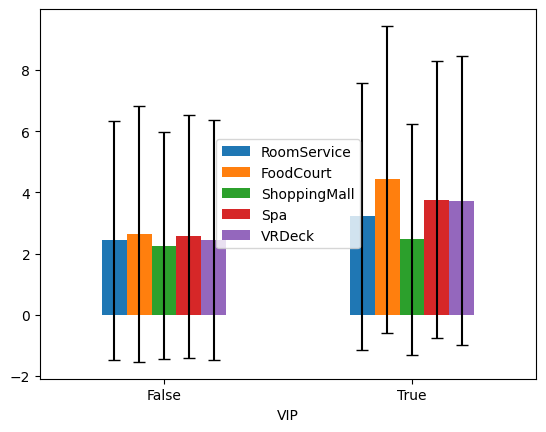

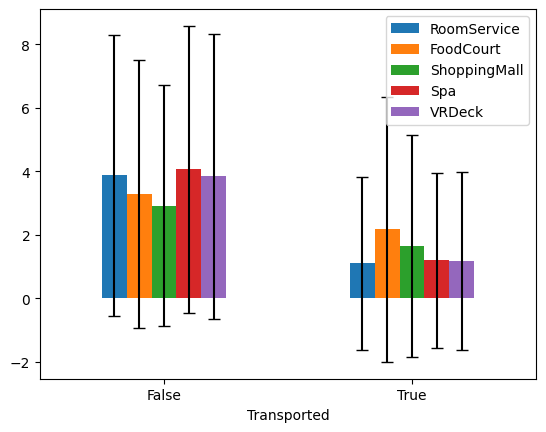

In [129]:
for i in categories:
    fig, ax = plt.subplots()
    gb = df1[([i] + expenses)].groupby([i])
    gb.mean().plot.bar(yerr=gb.std(), ax=ax, capsize=4, rot=0);

This Deck variable looks linar. Let's linearize it.

In [130]:
df1['Deck'] = df1['Deck'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8})

In [131]:
df1['Deck'].value_counts()

6.0    2794
7.0    2559
5.0     876
2.0     779
3.0     747
4.0     478
1.0     256
8.0       5
Name: Deck, dtype: int64

Let's look at side of ship.

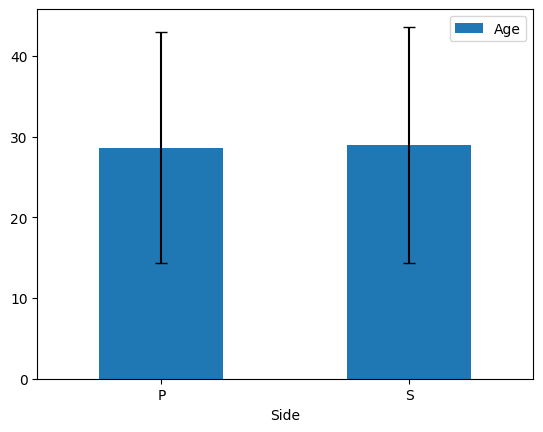

In [132]:
fig, ax = plt.subplots()
gb = df1[['Side', 'Age']].groupby(['Side'])
gb.mean().plot.bar(yerr=gb.std(), ax=ax, capsize=4, rot=0);

It looks completely random, so let's remove it from dataframe for now.

In [133]:
df1 = df1.drop('Side', axis=1)
categories.remove('Side')

Now look at categorical data.

In [134]:
i = 0
df1[[categories[i], "Transported"]].groupby([categories[i]], as_index=False).mean().sort_values(by='Transported',ascending=False)

,HomePlanet,Transported
1,Europa,0.658846
2,Mars,0.523024
0,Earth,0.423946


In [135]:
i = 1
df1[[categories[i], "Transported"]].groupby([categories[i]], as_index=False).mean().sort_values(by='Transported',ascending=False)

,Destination,Transported
0,55 Cancri e,0.610000
1,PSO J318.5-22,0.503769
2,TRAPPIST-1e,0.471175


In [136]:
i = 2
df1[[categories[i], "Transported"]].groupby([categories[i]], as_index=False).mean().sort_values(by='Transported',ascending=False)

,Deck,Transported
1,2.0,0.734275
2,3.0,0.680054
6,7.0,0.516217
0,1.0,0.496094
5,6.0,0.439871
3,4.0,0.433054
4,5.0,0.357306
7,8.0,0.200000


In [137]:
i = 3
df1[[categories[i], "Transported"]].groupby([categories[i]], as_index=False).mean().sort_values(by='Transported',ascending=False)

,CryoSleep,Transported
1,True,0.795636
0,False,0.328921


In [138]:
i = 4
df1[[categories[i], "Transported"]].groupby([categories[i]], as_index=False).mean().sort_values(by='Transported',ascending=False)

,VIP,Transported
0,False,0.506332
1,True,0.447761


Looks like thare are no more outlayers, so look at the realtions.

<ipython-input-139-58b334de199a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df1.corr())


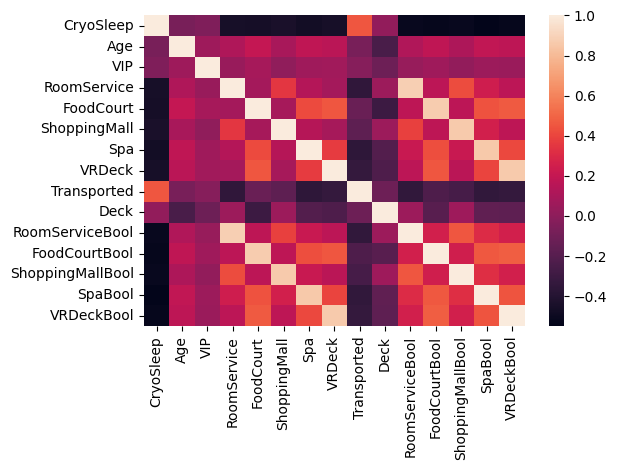

In [139]:
sns.heatmap(df1.corr())
plt.tight_layout()

Let's zoom in.

<ipython-input-140-35fa4a53fab2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df1.drop(expenses, axis=1).corr(), annot=True)


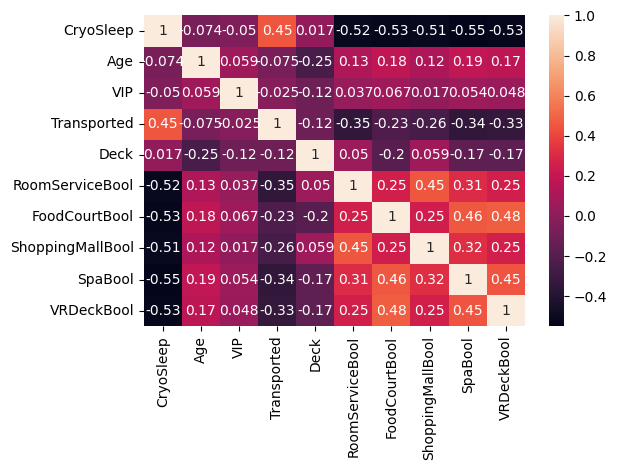

In [140]:
sns.heatmap(df1.drop(expenses, axis=1).corr(), annot=True)
plt.tight_layout()

<ipython-input-141-0de678839c37>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df1.drop(expensesBool, axis=1).corr(), annot=True)


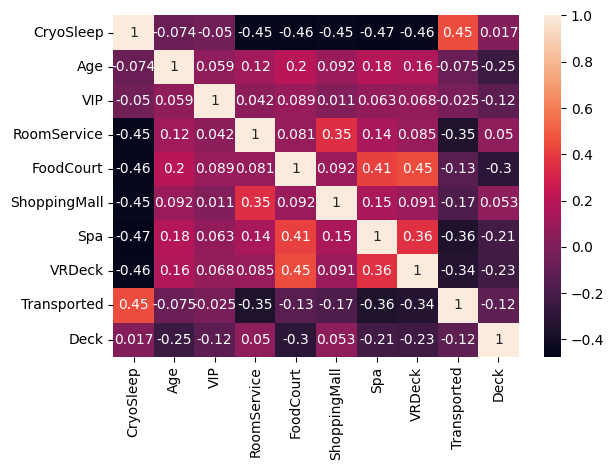

In [141]:
sns.heatmap(df1.drop(expensesBool, axis=1).corr(), annot=True)
plt.tight_layout()

Seems like boolean variables coreleate better with "Transported".

array([[<Axes: xlabel='Age', ylabel='Age'>,
        <Axes: xlabel='RoomService', ylabel='Age'>,
        <Axes: xlabel='FoodCourt', ylabel='Age'>,
        <Axes: xlabel='ShoppingMall', ylabel='Age'>,
        <Axes: xlabel='Spa', ylabel='Age'>,
        <Axes: xlabel='VRDeck', ylabel='Age'>],
       [<Axes: xlabel='Age', ylabel='RoomService'>,
        <Axes: xlabel='RoomService', ylabel='RoomService'>,
        <Axes: xlabel='FoodCourt', ylabel='RoomService'>,
        <Axes: xlabel='ShoppingMall', ylabel='RoomService'>,
        <Axes: xlabel='Spa', ylabel='RoomService'>,
        <Axes: xlabel='VRDeck', ylabel='RoomService'>],
       [<Axes: xlabel='Age', ylabel='FoodCourt'>,
        <Axes: xlabel='RoomService', ylabel='FoodCourt'>,
        <Axes: xlabel='FoodCourt', ylabel='FoodCourt'>,
        <Axes: xlabel='ShoppingMall', ylabel='FoodCourt'>,
        <Axes: xlabel='Spa', ylabel='FoodCourt'>,
        <Axes: xlabel='VRDeck', ylabel='FoodCourt'>],
       [<Axes: xlabel='Age', ylabel='Shoppi

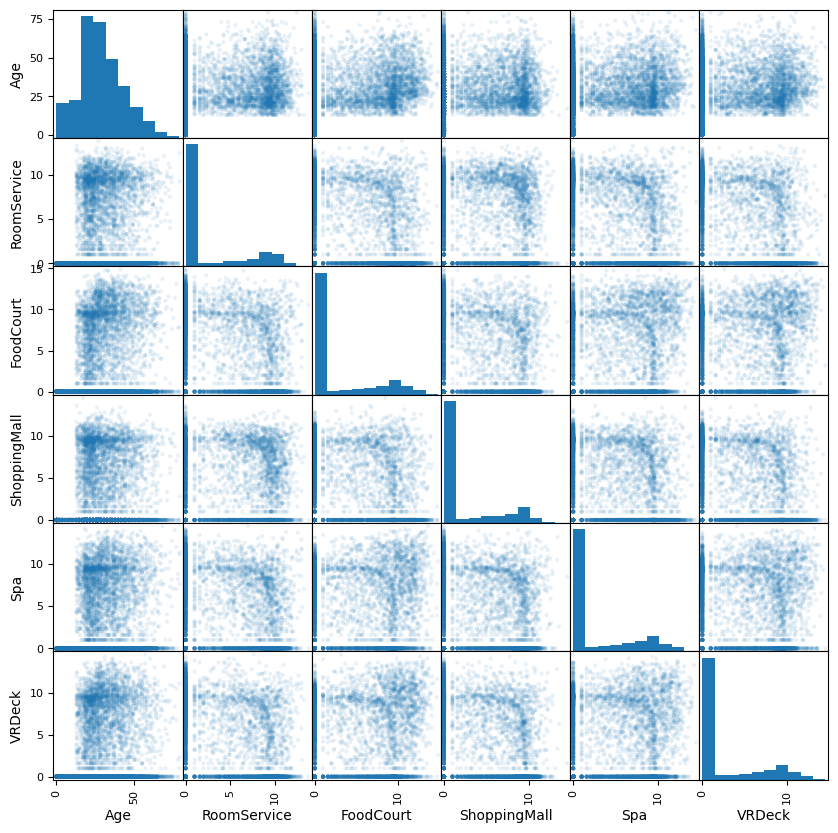

In [142]:
scatter_matrix(df1[['Age',  'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']],
               alpha=0.1, figsize=(10, 10), diagonal='hist')

Looks boring. Lets train some model.

In [143]:
encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(df1[nonBinaryCategories])
temp = pd.DataFrame(encoded, columns=np.hstack(encoder.categories_))
df2 = pd.concat((df1, temp), axis=1).drop(nonBinaryCategories, axis=1)
df2 = df2.loc[:, df2.columns.notna()]
df2 = df2.dropna()


xTrain, xTest, yTrain, yTest = train_test_split(df2[df2.columns.difference(["Transported"])].values, df2['Transported'].values, test_size = 0.2)

model = DecisionTreeClassifier()
model.fit(xTrain, yTrain)
cm = confusion_matrix(yTest, model.predict(xTest))
cm = np.array((cm*100)/cm.sum(), dtype=int)
print(cm[0], cm[1], cm[0][0] + cm[1][1])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[36 13] [13 36] 72


It looks fine. Let's randomly remove columns.

In [144]:
from itertools import combinations

x = [1,2,3]
y = {1:[4,5], 2:[6,7]}

def generate_combinations(iterable):
    for i in range(1, len(iterable) + 1):
        for combination in combinations(iterable, i):
            yield combination

def replace(iterable, replacement_dict):
    result = []
    for j in iterable:
        if j in replacement_dict:
            result.extend(replacement_dict[j])
        else:
            result.append(j)
    return result

for i in generate_combinations(x):
    print(i, replace(i,y))

(1,) [4, 5]
(2,) [6, 7]
(3,) [3]
(1, 2) [4, 5, 6, 7]
(1, 3) [4, 5, 3]
(2, 3) [6, 7, 3]
(1, 2, 3) [4, 5, 6, 7, 3]


In [145]:
columns = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', "Expenses",
           'Deck', 'CabinNum', 'ExpensesBool',]


replacement = {'Expenses': expenses, 'ExpensesBool': expensesBool,
           'HomePlanet': ['Earth', 'Europa', 'Mars'],
           'Destination': [ '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e']}

In [146]:
xTrain = pd.DataFrame(xTrain, columns=df2.columns.difference(["Transported"]))
xTest = pd.DataFrame(xTest, columns=df2.columns.difference(["Transported"]))

result = []

for i in generate_combinations(columns):

    xTr = xTrain[replace(i, replacement)]
    xTe = xTest[replace(i, replacement)]

    model.fit(xTr, yTrain)
    cm = confusion_matrix(yTest, model.predict(xTe))
    cm = np.array((cm*100)/cm.sum(), dtype=int)
    result.append(( i, cm, cm[0][0] + cm[1][1]))
    #print(cm[0], cm[1], cm[0][0] + cm[1][1], i)

In [147]:
result.sort(key=lambda x: x[2])

In [148]:
for i in result:
    print(i[1][0], i[1][1], i[1][0][0] + i[1][1][1])
    for j in i[0]:
        print(j)

    print("")

[ 1 47] [ 2 48] 49
VIP

[29 19] [28 22] 51
Destination
CabinNum

[26 22] [25 25] 51
Age
CabinNum

[28 20] [26 23] 51
VIP
CabinNum

[29 19] [27 22] 51
Destination
VIP
CabinNum

[26 23] [25 25] 51
Age
VIP
CabinNum

[35 13] [33 17] 52
Destination

[29 20] [26 23] 52
CabinNum

[36 12] [34 16] 52
Destination
VIP

[27 21] [24 25] 52
Destination
Deck
CabinNum

[27 22] [24 25] 52
Destination
VIP
Deck
CabinNum

[35 14] [31 18] 53
Age

[29 19] [25 24] 53
Deck
CabinNum

[27 21] [23 26] 53
Destination
Age
CabinNum

[29 20] [25 24] 53
VIP
Deck
CabinNum

[28 20] [25 25] 53
Age
VIP
Deck
CabinNum

[31 18] [26 23] 54
Destination
Age

[34 15] [30 20] 54
Age
VIP

[28 20] [23 26] 54
HomePlanet
Age
CabinNum

[30 18] [26 24] 54
HomePlanet
VIP
CabinNum

[31 18] [26 23] 54
Destination
Age
VIP

[27 21] [22 27] 54
HomePlanet
Destination
Age
CabinNum

[30 18] [25 24] 54
HomePlanet
Destination
VIP
CabinNum

[28 21] [24 26] 54
Destination
Age
VIP
CabinNum

[31 18] [26 24] 55
HomePlanet
CabinNum

[31 18] [26 24] 55

In [149]:
k = [(i, 4) for i in generate_combinations(['apple', 'banana', 'orange'])]

In [150]:
k

[(('apple',), 4),
 (('banana',), 4),
 (('orange',), 4),
 (('apple', 'banana'), 4),
 (('apple', 'orange'), 4),
 (('banana', 'orange'), 4),
 (('apple', 'banana', 'orange'), 4)]

In [151]:
df = pd.DataFrame(columns=columns)

# Iterate through the data and populate the DataFrame
for i in result:
    row = {j: True if j in i[0] else False for j in columns}
    row['value'] = i[2]
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

# Fill NaN values with False in boolean columns
df[columns] = df[columns].fillna(False)



<ipython-input-151-a7bd46cf66bd>:7: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
<ipython-input-151-a7bd46cf66bd>:7: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
<ipython-input-151-a7bd46cf66bd>:7: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
<ipython-input-151-a7bd46cf66bd>:7: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cas

In [152]:
df

,HomePlanet,CryoSleep,Destination,Age,VIP,Expenses,Deck,CabinNum,ExpensesBool,value
0,False,False,False,False,True,False,False,False,False,49.0
1,False,False,True,False,False,False,False,True,False,51.0
2,False,False,False,True,False,False,False,True,False,51.0
3,False,False,False,False,True,False,False,True,False,51.0
4,False,False,True,False,True,False,False,True,False,51.0
...,...,...,...,...,...,...,...,...,...,...
506,False,False,True,False,False,True,True,False,True,75.0
507,True,False,True,False,True,True,True,False,False,75.0
508,True,False,True,False,False,True,True,False,True,75.0
509,False,True,False,False,True,True,True,False,True,75.0


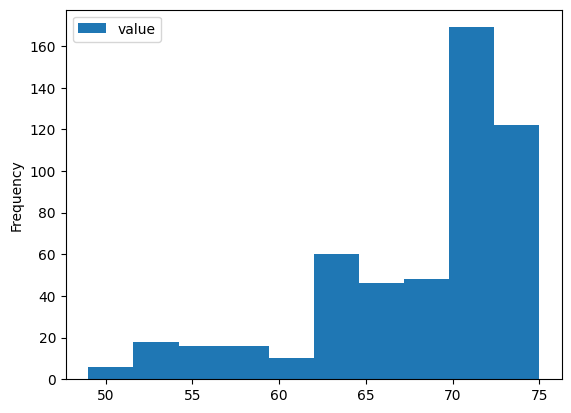

In [153]:
df[['value']].plot.hist();

In [154]:
len(columns)

9

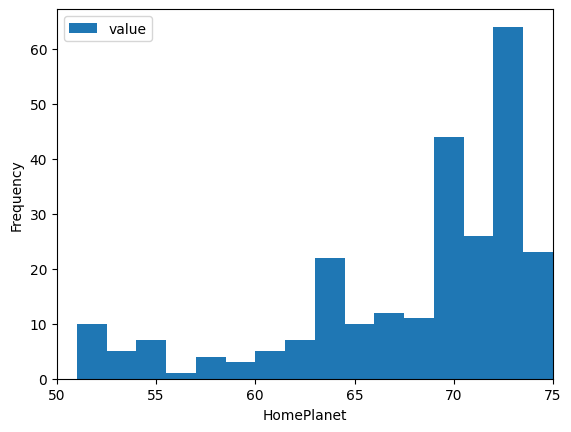

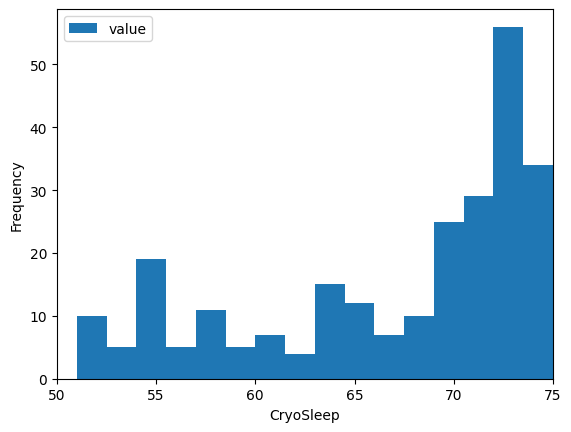

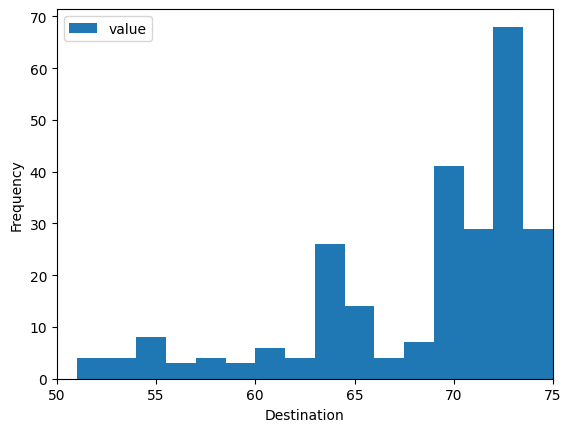

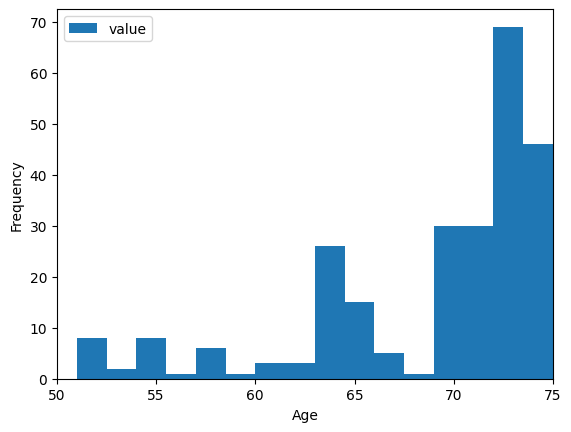

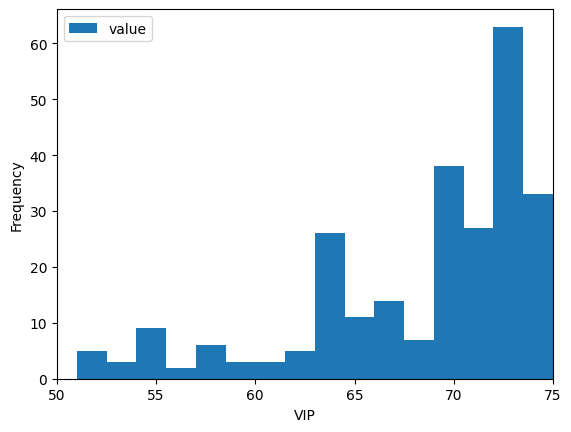

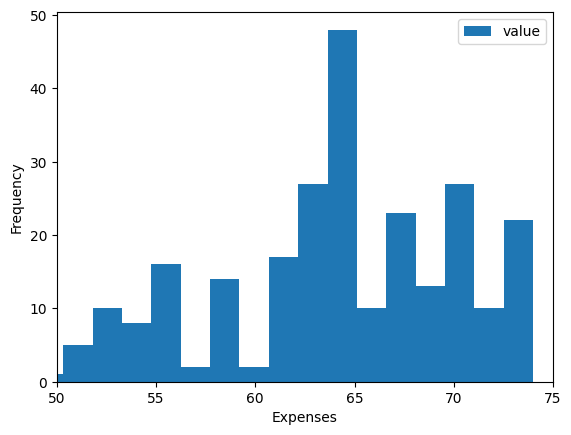

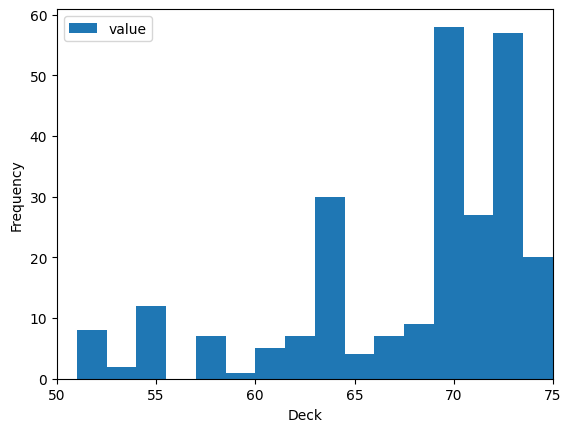

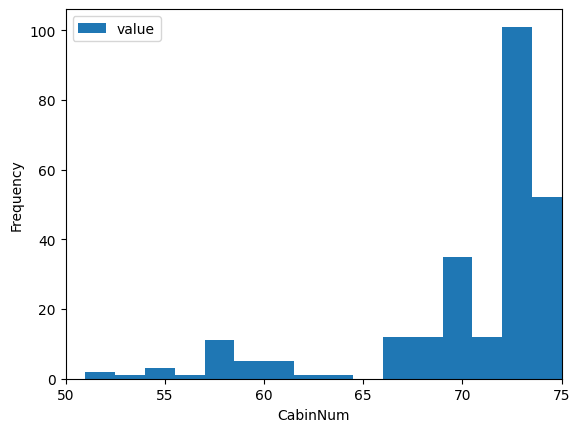

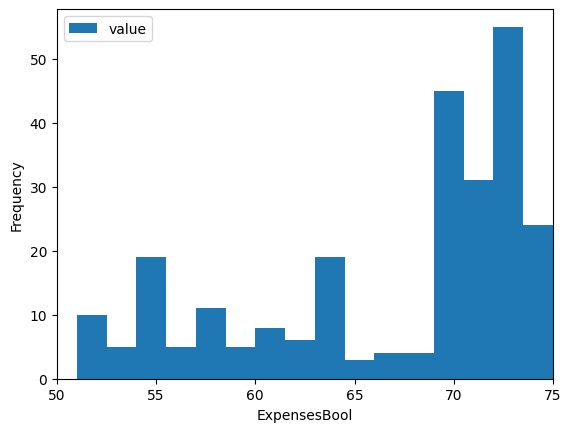

In [162]:
for i in columns:
    fig, ax = plt.subplots()
    plt.xlabel(i)
    plt.xlim(50,75)
    df[~df[i]].plot.hist(ax=ax,bins=50);

In [166]:
df[df['value'] > 67]

,HomePlanet,CryoSleep,Destination,Age,VIP,Expenses,Deck,CabinNum,ExpensesBool,value
172,False,False,True,True,False,False,False,False,True,68.0
173,False,False,False,True,False,True,False,True,False,68.0
174,False,False,False,True,False,False,True,False,True,68.0
175,True,False,False,True,False,False,True,False,True,68.0
176,False,True,True,True,False,False,True,False,False,68.0
...,...,...,...,...,...,...,...,...,...,...
506,False,False,True,False,False,True,True,False,True,75.0
507,True,False,True,False,True,True,True,False,False,75.0
508,True,False,True,False,False,True,True,False,True,75.0
509,False,True,False,False,True,True,True,False,True,75.0


# Milestone.

Looks decent. Now let's arbitarily cut some columns.

In [156]:
encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(df1[nonBinaryCategories])
temp = pd.DataFrame(encoded, columns=np.hstack(encoder.categories_))
df2 = pd.concat((df1, temp), axis=1).drop(nonBinaryCategories, axis=1)
df2 = df2.loc[:, df2.columns.notna()]
df2 = df2.dropna()

df2 = df2.drop(expenses, axis = 1)

xTrain, xTest, yTrain, yTest = train_test_split(df2[df2.columns.difference(["Transported"])].values, df2['Transported'].values, test_size = 0.2)
model = DecisionTreeClassifier()
model.fit(xTrain, yTrain)
cm = confusion_matrix(yTest, model.predict(xTest))
cm = np.array((cm*100)/cm.sum(), dtype=int)
print('\n\n\n', cm[0], cm[1], cm[0][0] + cm[1][1], '\n\n\n')




 [33 16] [16 33] 66 





/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


I made it worse, so I should take care of these.

In [157]:
encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(df1[nonBinaryCategories])
temp = pd.DataFrame(encoded, columns=np.hstack(encoder.categories_))
df2 = pd.concat((df1, temp), axis=1).drop(nonBinaryCategories, axis=1)
df2 = df2.loc[:, df2.columns.notna()]
df2 = df2.dropna()

df2 = df2.drop(['Age'], axis = 1)

xTrain, xTest, yTrain, yTest = train_test_split(df2[df2.columns.difference(["Transported"])].values, df2['Transported'].values, test_size = 0.2)
model = DecisionTreeClassifier()
model.fit(xTrain, yTrain)
cm = confusion_matrix(yTest, model.predict(xTest))
cm = np.array((cm*100)/cm.sum(), dtype=int)
print('\n\n\n', cm[0], cm[1], cm[0][0] + cm[1][1], '\n\n\n')




 [36 12] [14 36] 72 





/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Not much of a difference.

In [158]:
encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(df1[nonBinaryCategories])
temp = pd.DataFrame(encoded, columns=np.hstack(encoder.categories_))
df2 = pd.concat((df1, temp), axis=1).drop(nonBinaryCategories, axis=1)
df2 = df2.loc[:, df2.columns.notna()]
df2 = df2.dropna()

df2 = df2.drop(['CabinNum'], axis = 1)

xTrain, xTest, yTrain, yTest = train_test_split(df2[df2.columns.difference(["Transported"])].values, df2['Transported'].values, test_size = 0.2)
model = DecisionTreeClassifier()
model.fit(xTrain, yTrain)
cm = confusion_matrix(yTest, model.predict(xTest))
cm = np.array((cm*100)/cm.sum(), dtype=int)
print('\n\n\n', cm[0], cm[1], cm[0][0] + cm[1][1], '\n\n\n')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(





 [35 16] [10 37] 72 





In [159]:
model = DecisionTreeClassifier(splitter = 'random', criterion = 'log_loss', max_features = 'log2')
model.fit(xTrain, yTrain)
cm = confusion_matrix(yTest, model.predict(xTest))
cm = np.array((cm*100)/cm.sum(), dtype=int)
print('\n\n\n', cm[0], cm[1], cm[0][0] + cm[1][1], '\n\n\n')




 [35 16] [12 36] 71 



